<h1><center>Data Analysis with ACADEMY methodology</center></h1>
<h2><center>Analyzing the Composition, the modal Abundance and the Density using Electron MicroscopY</center></h2>

Here is an example of what it is possible to do using the ACADEMY methodology. 
For more informations please read Zanetta et al,. 2018 
Don't hesitate to contact the author via Github or directly by email.

## Author 

19/09/2018 Pierre-marie Zanetta

## requirements

HyperSpy 1.3 and need to merge the Pull request #1835 and #1462

### Before you start: 
We first import the different pacakges necessary to run the whole code

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
#import hyperspy.api as hs 

To obtain a merged version that run the entire code it is possible to download the branch "v1.3_background_and_linear" on my personnal github repository:
https://github.com/ZanettaPM/hyperspy/tree/Master_merged

clone this repository on a github folder in your documents and remplace the path below

In [2]:
import imp
hs=imp.load_source("hyperspy", "D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy/__init__.py")
hs=imp.load_source("hyperspy.api", "D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy/api.py")

In [3]:
hs.hyperspy.Release.version

'1.4.dev'

## Table of contents:
* [1. Description of the sample and getting started](#first-bullet)
* [2. Background modeling and spectrum fitting strategy](#second-bullet)
* [3. Mineral map and MLLS procedure](#third-bullet)
* [4. Density determination through bremstrahlung modelling](#fourth-bullet)
* [5. Calculation of the bulk composition](#fifth-bullet)

## 1. Description of the sample and getting started<a class="anchor" id="first-bullet"></a>


The sample consists of a cropped area of the map "Zone 2" of the meteorite of Paris presented in the paper.
This sample is investigated using a FEG-SEM JEOL JSM-7800F LV at the University of Lille equipped with an EDX/EBSD Aztec system from Oxford Instruments and a silicon drift detector (SDD XMaxN) of 80 mm². 

Initially the raw file extracted from Aztech was composed of 3 files: ".msa", ".rpl" and the ".raw"
The ".msa" file contains a single pixel spectrum and the metadata to calibrate it. The ".rpl" is a header to read the ".raw". The ".raw" file contains an EDS/SEM spectral image.
These data have been cropped and converted into the hyperspy format ".hspy", and the metadata have been completed

In [4]:
s=hs.load("data.hspy")
s

<EDSSEMSpectrum, title: Map Sum Spectrum, dimensions: (97, 110|512)>

In [5]:
s.metadata

├── Acquisition_instrument
│   └── SEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 29.0
│       │       ├── energy_resolution_MnKa = 130.0
│       │       ├── live_time = 170393.59375
│       │       └── real_time = 210312.96875
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       ├── beam_energy = 5.0
│       └── magnification = X440
├── General
│   ├── date = 2017-01-24
│   ├── original_filename = Paris_section-6_Map2
│   ├── time = 17:42:00
│   └── title = Map Sum Spectrum
├── Sample
│   ├── elements = ['Al', 'C', 'Ca', 'Fe', 'Mg', 'Na', 'Ni', 'O', 'S', 'Si']
│   └── xray_lines = ['Al_Ka', 'C_Ka', 'Ca_La', 'Fe_La', 'Mg_Ka', 'Na_Ka', 'Ni_La', 'O_Ka', 'S_Ka', 'Si_Ka']
└── Signal
    ├── binned = True
    ├── quantity = X-rays (Counts)
    └── signal_type = EDS_SEM

We plot the hyperspectral signal and the different X-ray lines.
The signal have been calibrated in energy beforehand

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


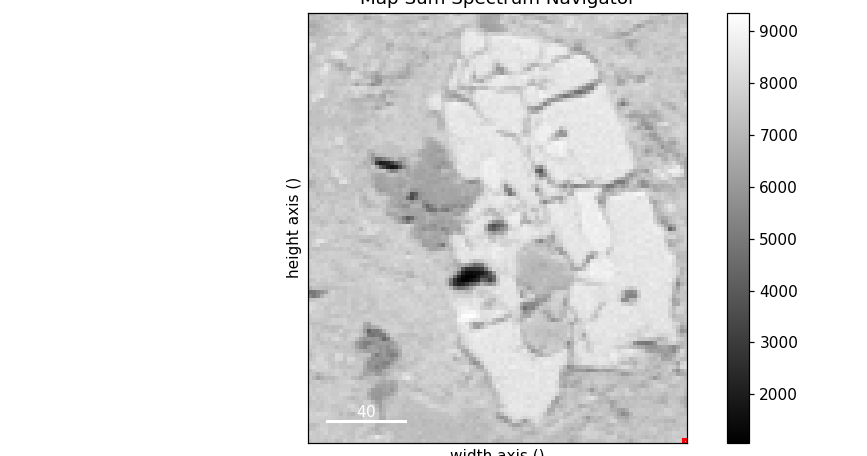

<IPython.core.display.Javascript object>


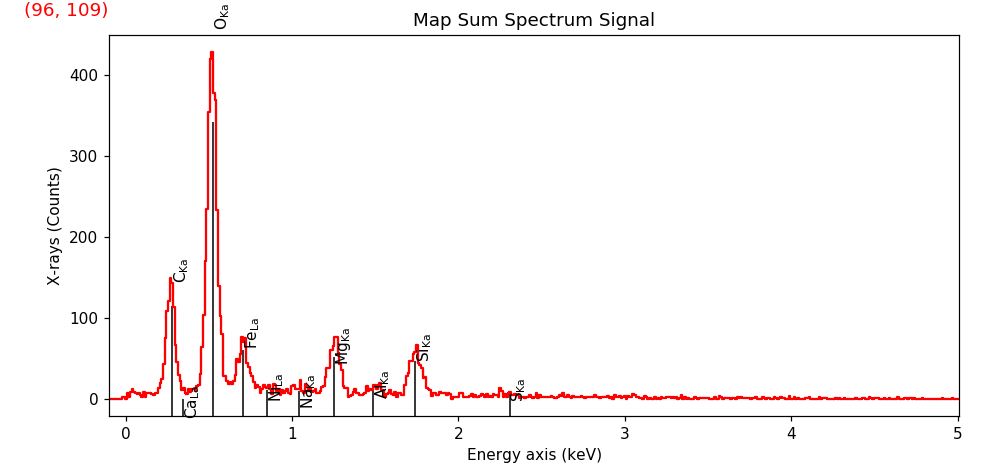

In [51]:
s.plot(True) 

## 2.	Background modeling and spectrum fitting strategy<a class="anchor" id="second-bullet"></a>

To obtain accurate elemental maps, we create a model to remove the background and we fit gaussian functions to the hyperspectral map.

The default background proposed by hyperspy is a polynome function. Here we don't use this components but we add another background taking into account the emission and the absorption within the sample and the detector. 
To see the code behind this component please refer to the pull request #1835

In [7]:
m=s.create_model(auto_background=False)

The thin window in front of our detector is a polymer window. We use the efficiency curve modelised beforehand.

In [8]:
m.add_physical_background(detector='Polymer_C',quantification=None)

In first instance we approximate the composition of each pixel based on the height of the peaks. This approximation is necessary to obtain a shape of of the background which fit well with the data.

In [9]:
m.components.Bremsstrahlung.initialize()

D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:307: RuntimeWarning: divide by zero encountered in log
  mac_res = np.exp(np.log(macs[index - 1]) +
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:308: RuntimeWarning: divide by zero encountered in true_divide
  np.log(macs[index] / macs[index - 1]) *
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: divide by zero encountered in true_divide
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: invalid value encountered in log
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: divide by zero encountered in true_divide
  np.log(energies_db[index] / energies_db[index - 1])))
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: invalid valu

{'Quant map has been created'}

We print the differents components of the model and we can delete X-ray lines with weak intensity to speed up the fitting procedure.

In [10]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               Al_Ka |               Al_Ka |            Gaussian
   1 |               Al_Kb |               Al_Kb |            Gaussian
   2 |                C_Ka |                C_Ka |            Gaussian
   3 |               Ca_Ka |               Ca_Ka |            Gaussian
   4 |               Ca_Kb |               Ca_Kb |            Gaussian
   5 |               Ca_La |               Ca_La |            Gaussian
   6 |               Ca_Ln |               Ca_Ln |            Gaussian
   7 |               Ca_Ll |               Ca_Ll |            Gaussian
   8 |               Fe_La |               Fe_La |            Gaussian
   9 |               Fe_Ll |               Fe_Ll |            Gaussian
  10 |               Fe_Ln |               Fe_Ln |            Gaussian
  11 |              Fe_Lb3 |              Fe_Lb3 |            Gaussian
  12 |

In [11]:
m.remove([1,6,7,9,10,11,13,15,20])

In [12]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               Al_Ka |               Al_Ka |            Gaussian
   1 |                C_Ka |                C_Ka |            Gaussian
   2 |               Ca_Ka |               Ca_Ka |            Gaussian
   3 |               Ca_Kb |               Ca_Kb |            Gaussian
   4 |               Ca_La |               Ca_La |            Gaussian
   5 |               Fe_La |               Fe_La |            Gaussian
   6 |               Mg_Ka |               Mg_Ka |            Gaussian
   7 |               Na_Ka |               Na_Ka |            Gaussian
   8 |               Ni_La |               Ni_La |            Gaussian
   9 |               Ni_Ll |               Ni_Ll |            Gaussian
  10 |              Ni_Lb1 |              Ni_Lb1 |            Gaussian
  11 |               Ni_Ln |               Ni_Ln |            Gaussian
  12 |

Finally, we fit the background to the data. The background cannot be negative, in consequence we fix bounds. 

In [13]:
m.fit_background(kind='multi',bounded=True, windows_sigma=([3,3]))

D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:307: RuntimeWarning: divide by zero encountered in log
  mac_res = np.exp(np.log(macs[index - 1]) +
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:308: RuntimeWarning: divide by zero encountered in true_divide
  np.log(macs[index] / macs[index - 1]) *
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: divide by zero encountered in true_divide
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: invalid value encountered in log
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: divide by zero encountered in true_divide
  np.log(energies_db[index] / energies_db[index - 1])))
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: invalid valu

And we fit the gaussians using the linear fit proposed by thomas aarholt (already merged in "v1.3_background_and_linear")
https://github.com/hyperspy/hyperspy/pull/1462

In [14]:
m.fix_background()

In [15]:
m.multifit(fitter='linear',bounded=True,grad=True)

(512,)


D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:307: RuntimeWarning: divide by zero encountered in log
  mac_res = np.exp(np.log(macs[index - 1]) +
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:308: RuntimeWarning: divide by zero encountered in true_divide
  np.log(macs[index] / macs[index - 1]) *
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: divide by zero encountered in true_divide
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: invalid value encountered in log
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: divide by zero encountered in true_divide
  np.log(energies_db[index] / energies_db[index - 1])))
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: invalid valu

(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)
(512,)
(512,)


(512,)
(512,)


(512,)
(512,)


(512,)
(512,)
(512,)
(512,)



<IPython.core.display.Javascript object>


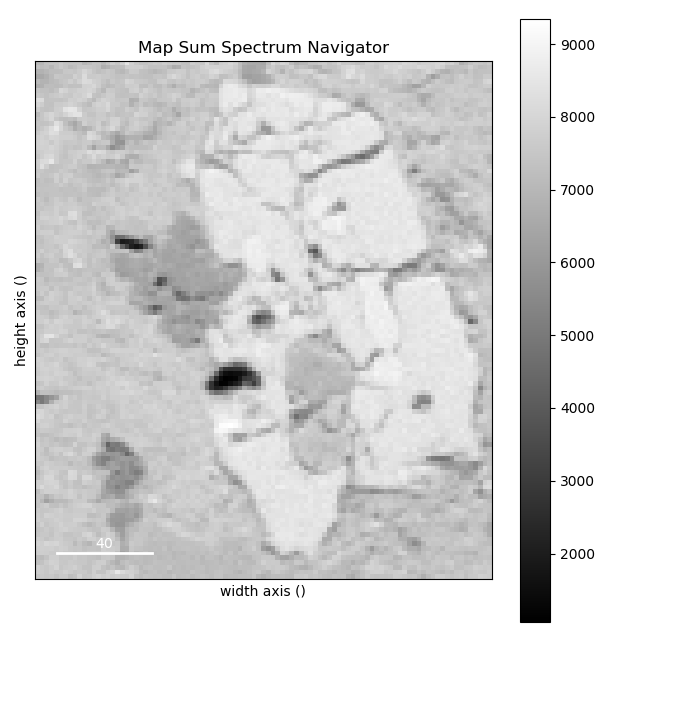

<IPython.core.display.Javascript object>


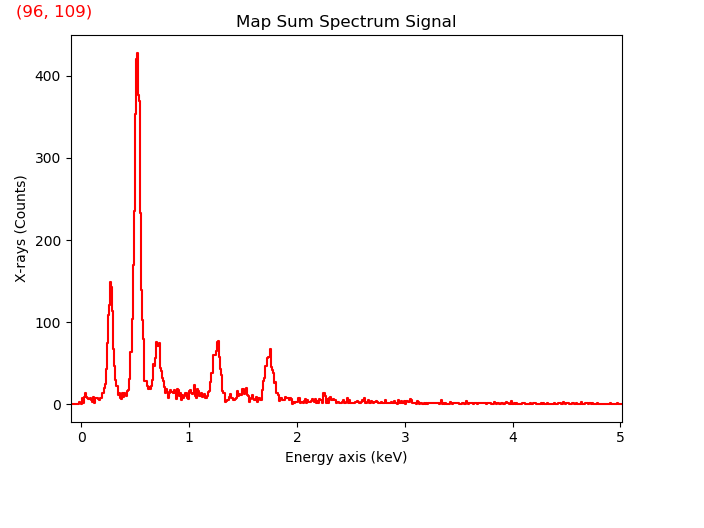

D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:307: RuntimeWarning: divide by zero encountered in log
  mac_res = np.exp(np.log(macs[index - 1]) +
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:308: RuntimeWarning: divide by zero encountered in true_divide
  np.log(macs[index] / macs[index - 1]) *
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: divide by zero encountered in true_divide
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: invalid value encountered in log
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: divide by zero encountered in true_divide
  np.log(energies_db[index] / energies_db[index - 1])))
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: invalid valu

In [16]:
m.plot(plot_components=True)

We extract the different elementary map in order to use clustering methods to classify pixel of composition fields
Here we plot the Mg map corresponding to the integrated peak after the background removing

<IPython.core.display.Javascript object>


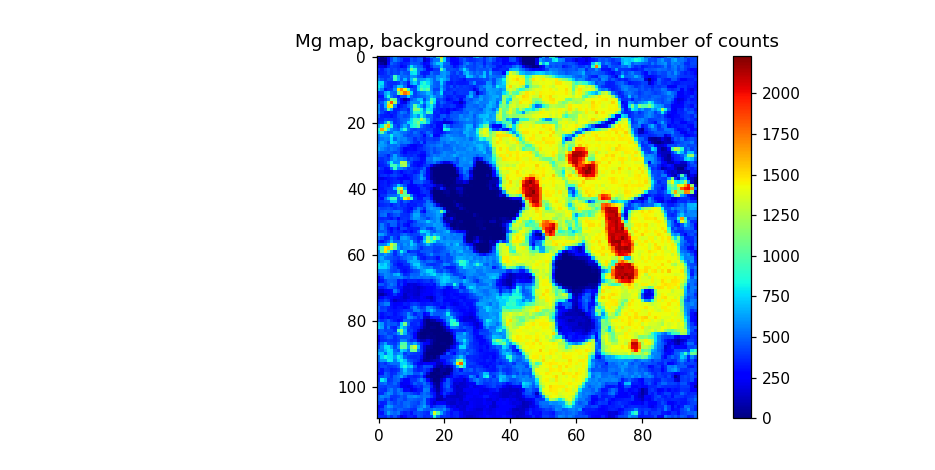

In [17]:
elemap=m.get_lines_intensity()
plt.figure()
plt.imshow(elemap[5],cmap='jet')
plt.title('Mg map, background corrected, in number of counts')
plt.colorbar()

## 3. Mineral map and MLLS procedure <a class="anchor" id="third-bullet"></a>

The phase map have been obtained using XmapTools software and manual refinement on matlab software. However, such clustering methods exist in python and have been proposed into hyperspy: 
https://github.com/hyperspy/hyperspy/pull/1353

Here to continue the example, a file containing the value of the map is provided in the repository of this tutorial

In [18]:
carto=hs.load('cartography.hspy')

In [19]:
phases=['Metal Grain','Olivine','Pyroxene','Fe-rich sulfides','Epoxy','Pentlandite','Mg-rich phyll/amorph','Fe-rich phyll/amorph','Carbonates'
,'Spinel','sulfates','Olivine (Fo<90)']

We first plot the phase map

<IPython.core.display.Javascript object>


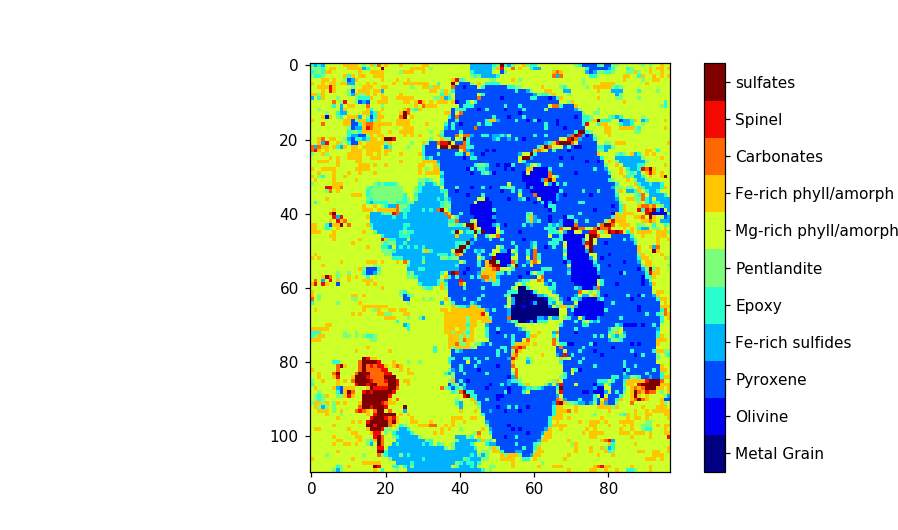

In [20]:
plt.figure()
plt.imshow(carto,plt.get_cmap('jet', 11))
cb = plt.colorbar()    
cb.set_ticks([1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5])
cb.set_ticklabels(['Metal Grain','Olivine','Pyroxene','Fe-rich sulfides','Epoxy','Pentlandite','Mg-rich phyll/amorph','Fe-rich phyll/amorph','Carbonates'
,'Spinel','sulfates','Olivine (Fo<90)'])


We create a new model that will contain the refence spectra of the MLLS procedure

In [21]:
m2 = s.create_model(False,False)

Ideally we use selected spectrum from the reference grains. Here a simple mean spectrum from all pixels of each phase is calculated

In [22]:
carto=np.array(carto.data)
a=int(np.max(carto))
Sref=dict()
indice=dict()
for i in range (1,a+1):
    s2=s.data[carto==i]
    s2=hs.signals.EDSSEMSpectrum(s2)
    s2=s2.mean()
    s2.get_calibration_from(s) 
    s2.metadata=s.metadata 
    Sref[i]=s2
    indice[i]=i

One of the reference spectrum is plotted

<IPython.core.display.Javascript object>


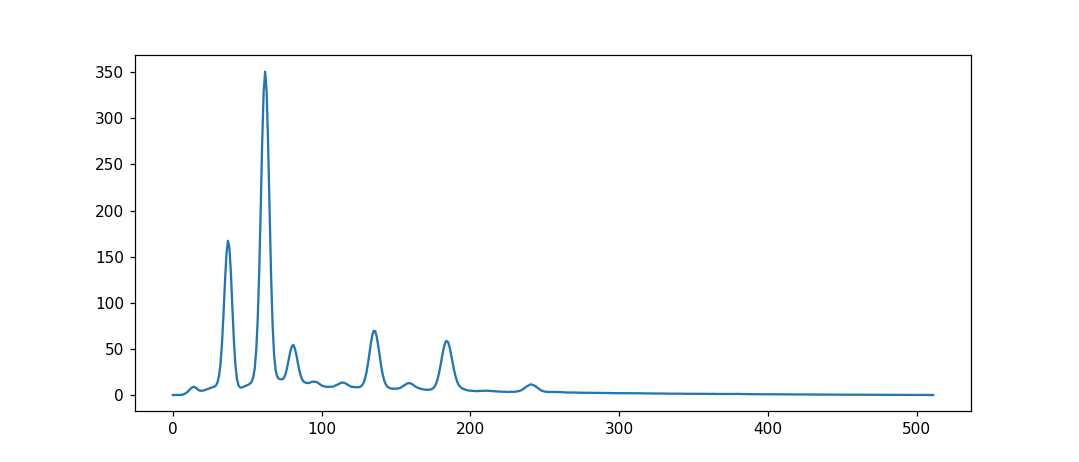

In [23]:
plt.figure()
plt.plot(Sref[8])

We add the reference spectra as component of the new model

In [24]:
for i in range (1,a+1):
    g=hs.model.components1D.ScalableFixedPattern(Sref[i])
    m2.extend([g])

In [25]:
m2.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   1 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   2 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   3 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   4 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   5 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   6 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   7 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   8 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
   9 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
  10 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..
  11 | ScalableFixedPatt.. | ScalableFixedPatt.. | ScalableFixedPatt..

The only free parameter is the Yscale, other are fixed. The yscale is bounded between 0 and 1 to obtain a percentage of the different phases

In [26]:
for i in range (0,len(m2)):
    m2.set_parameters_not_free([i], parameter_name_list=['xscale','shift'])
    m2.set_parameters_value('yscale',value=0.5,component_list=[i])
    m2[i].yscale.bmin=0
    m2[i].yscale.bmax=1

In [27]:
m2.multifit(fitter='linear',bounded=True, grad=True)

We plot maps of "proportion in each pixel" of the different phases

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


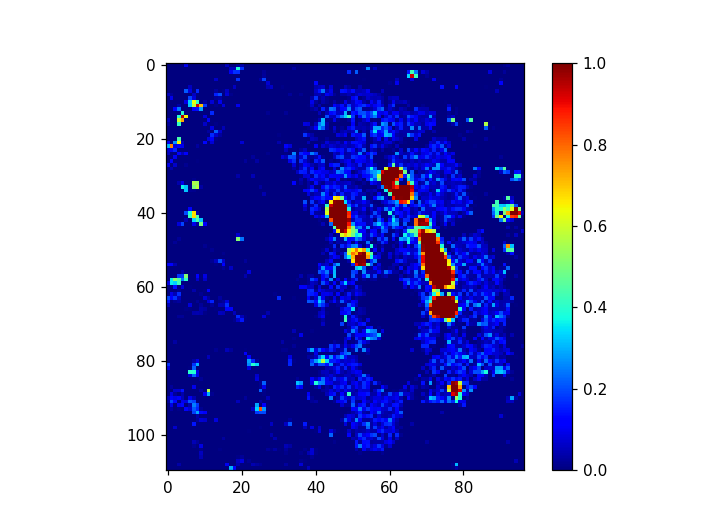

<IPython.core.display.Javascript object>


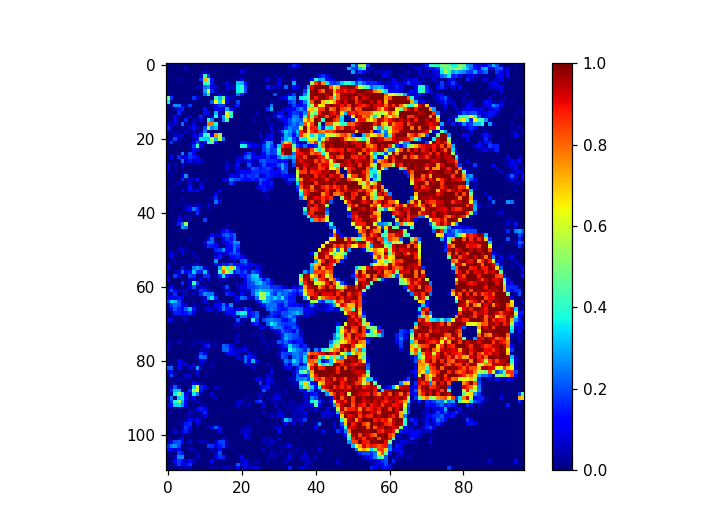

<IPython.core.display.Javascript object>


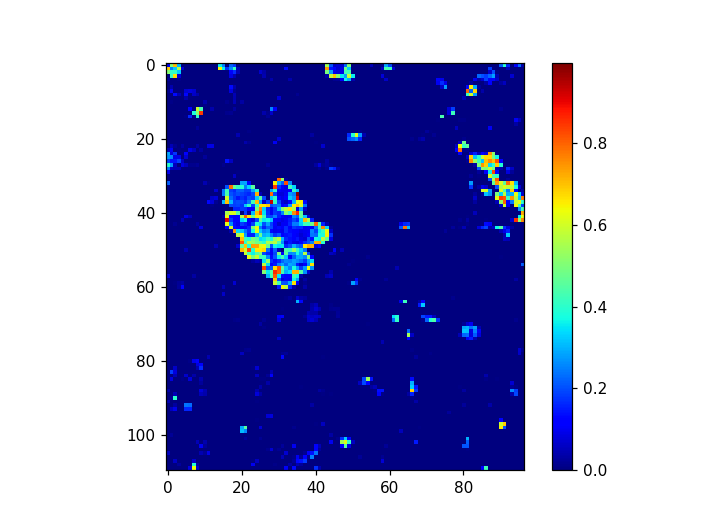

<IPython.core.display.Javascript object>


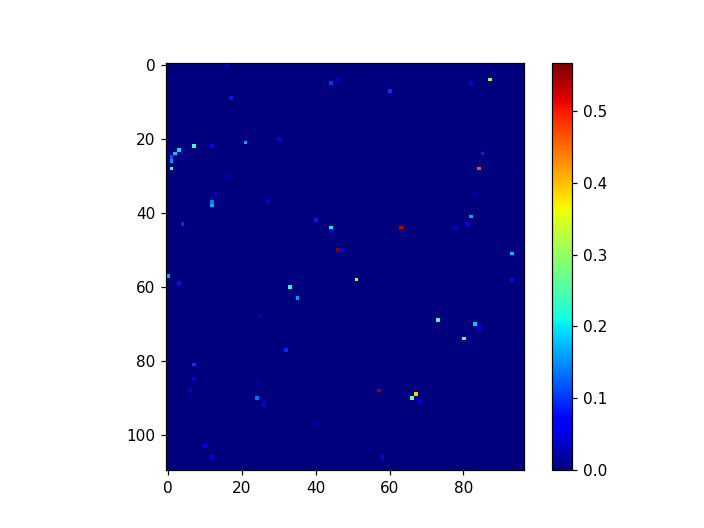

<IPython.core.display.Javascript object>


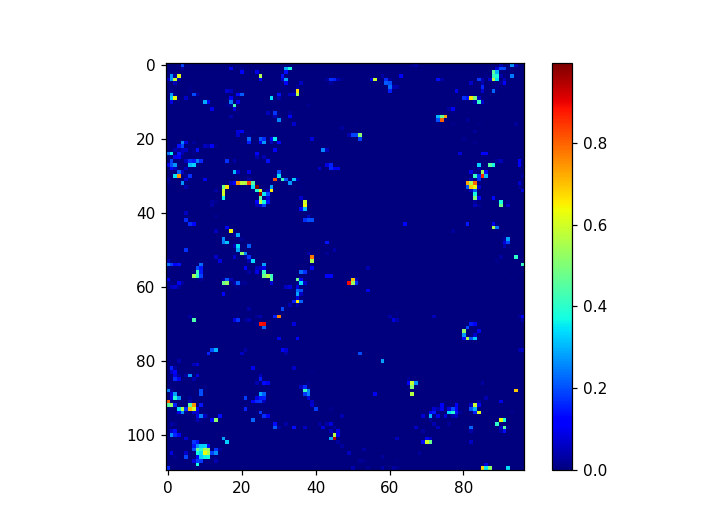

<IPython.core.display.Javascript object>


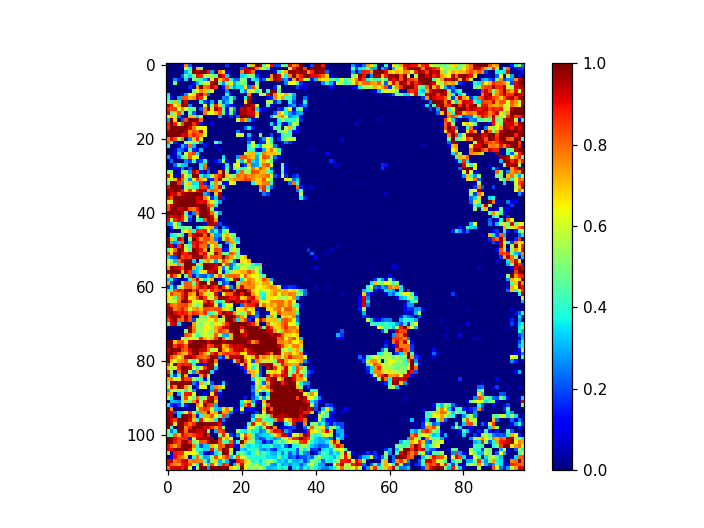

<IPython.core.display.Javascript object>


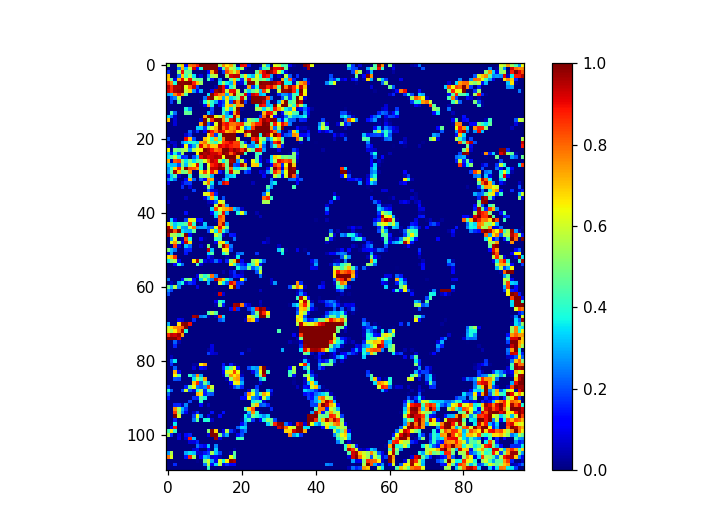

<IPython.core.display.Javascript object>


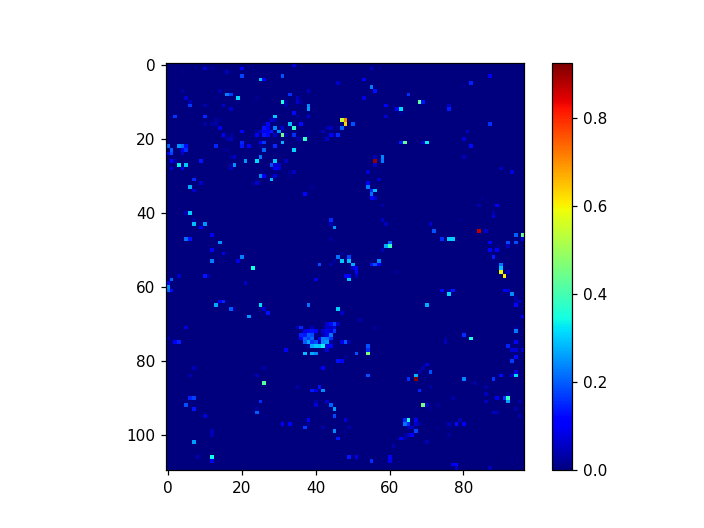

<IPython.core.display.Javascript object>


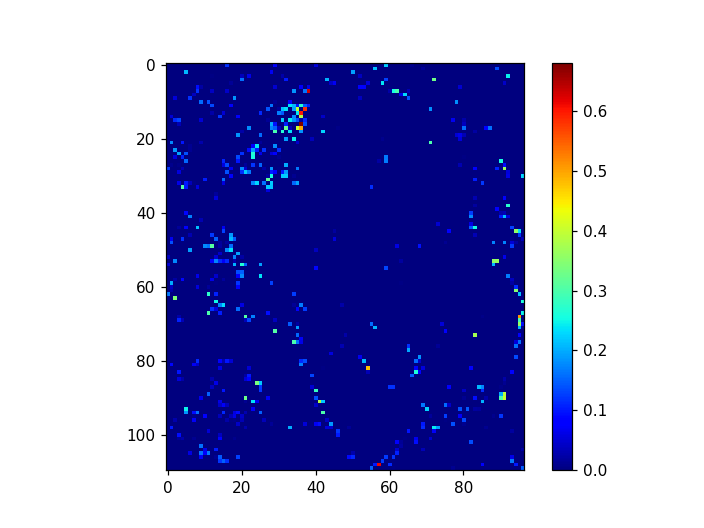

<IPython.core.display.Javascript object>


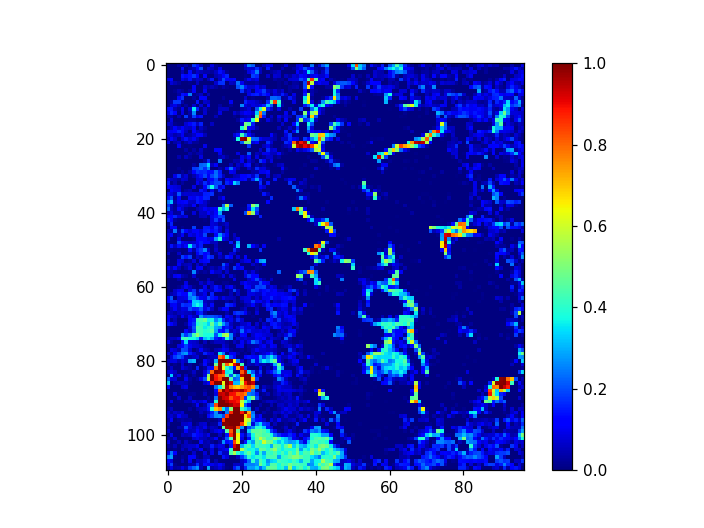

<IPython.core.display.Javascript object>


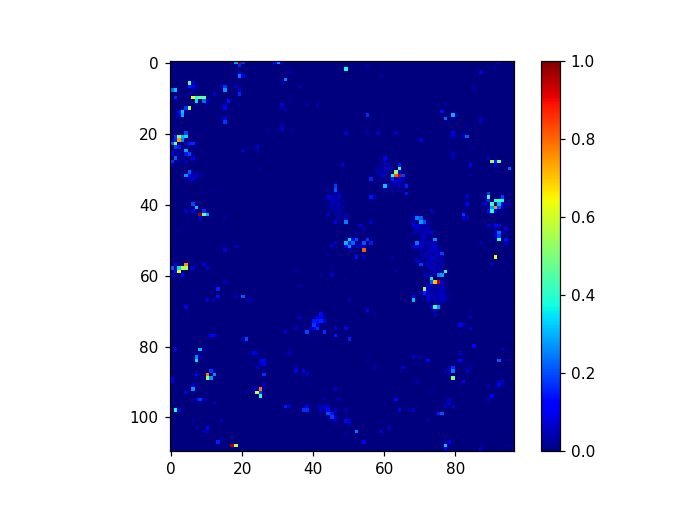

In [28]:
for i in range(0,len(m2)):
    a=m2[i].yscale.map['values']
    plt.figure()
    plt.imshow(a,cmap='jet')
    plt.colorbar()

# 4. Density determination through bremstrahlung modelling <a class="anchor" id="fourth-bullet"></a>

We have now corrected our modal abundances and the different reference grains have been analyzed using EPMA. Thanks to this measurements we know the composition of the different phases. Thoses compositions will be used for the density measurement of the hyperspectral map. 

In [29]:
Metal_grain=[0,1,0,95,0,0,4,0,0,0]
Olivine=[0,1,0,1.7,30,0,0,43.28,0,18.7]
Pyroxene=[0,1,0,0,22.9,0,0,48.32,0,28.54]
Fe_sulfides=[0,1,0,55.94,0,0,3.80,0,34.6,0]
Epoxy=[0,70,0,0,0,0,0,30,0,0]
Pentlandite=[0,1,0,32.5,0,0,22.5,0,27.3,0]
Mg_phyll=[1.599,1,0.87,16.05,10.20,0.6,1.2,33.27,3.30,14.059]
Fe_phyll=[1.67,1,0.39,20.87,7.43,0.7,1.17,29.75,2.22,12.5572]
Carbonates=[0,40,39.46,1.11,0,0.3,0,17.31,0,0]
Spinel=[0,0,3.64,19.751,8,0,0,36.89,3.6,12.83]
Sulfate=[2,13.02,8.50,12.34,7.49,2,0,33.52,6,11]
Fayalite=[0,0,0,16,23.21,0,0,41.6,0,18.6]
Elmt=[Metal_grain,Olivine,Pyroxene,Fe_sulfides,Epoxy,Pentlandite,Mg_phyll,Fe_phyll,Carbonates,Spinel,Sulfate,Fayalite]

A mask with the spatial dimension of the map and with the spectral dimension of the number element is created

In [30]:
x=np.shape(carto)
mask2=[]
mask2=np.ones([x[0],x[1],10])
mask2=hs.signals.EDSSEMSpectrum(mask2)

<IPython.core.display.Javascript object>


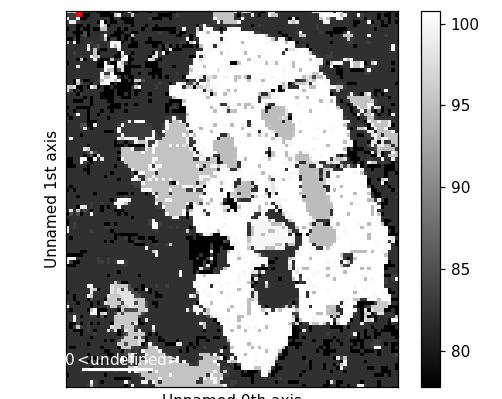

<IPython.core.display.Javascript object>


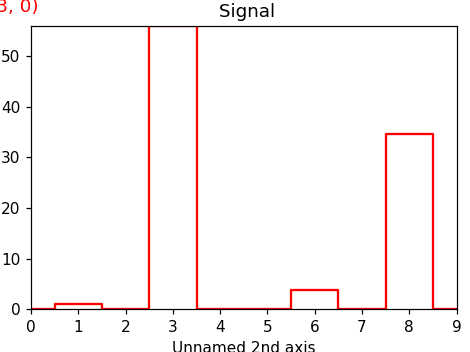

In [31]:
for i in range (0,12):
    a=np.where(carto==(i+1))
    x=np.shape(a)
    for u in range (0,x[1]):
        g=a[0]
        h=a[1]
        mask2.inav[h[u],g[u]] =Elmt[i]
mask2.plot()

In [32]:
quanti=np.array(mask2.data,float)
np.shape(quanti)

(110, 97, 10)

We create a new model again base on the same signal but this time we use de quantification

In [33]:
m3=s.create_model(auto_background=False)

In [34]:
m3.add_physical_background(detector='Polymer_C',quantification=quanti)

In [35]:
m3.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               Al_Ka |               Al_Ka |            Gaussian
   1 |               Al_Kb |               Al_Kb |            Gaussian
   2 |                C_Ka |                C_Ka |            Gaussian
   3 |               Ca_Ka |               Ca_Ka |            Gaussian
   4 |               Ca_Kb |               Ca_Kb |            Gaussian
   5 |               Ca_La |               Ca_La |            Gaussian
   6 |               Ca_Ln |               Ca_Ln |            Gaussian
   7 |               Ca_Ll |               Ca_Ll |            Gaussian
   8 |               Fe_La |               Fe_La |            Gaussian
   9 |               Fe_Ll |               Fe_Ll |            Gaussian
  10 |               Fe_Ln |               Fe_Ln |            Gaussian
  11 |              Fe_Lb3 |              Fe_Lb3 |            Gaussian
  12 |

In [36]:
m3.remove([1,6,7,9,10,11,13,15,20])

In [37]:
m3.components.Bremsstrahlung.initialize()

D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:307: RuntimeWarning: divide by zero encountered in log
  mac_res = np.exp(np.log(macs[index - 1]) +
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:308: RuntimeWarning: divide by zero encountered in true_divide
  np.log(macs[index] / macs[index - 1]) *
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: divide by zero encountered in true_divide
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: invalid value encountered in log
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: divide by zero encountered in true_divide
  np.log(energies_db[index] / energies_db[index - 1])))
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: invalid valu

{'Quant map has been created'}

In [38]:
m3.fit_background(kind='multi',bounded=True, windows_sigma=[3,3])

D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:307: RuntimeWarning: divide by zero encountered in log
  mac_res = np.exp(np.log(macs[index - 1]) +
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:308: RuntimeWarning: divide by zero encountered in true_divide
  np.log(macs[index] / macs[index - 1]) *
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: divide by zero encountered in true_divide
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: invalid value encountered in log
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: divide by zero encountered in true_divide
  np.log(energies_db[index] / energies_db[index - 1])))
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: invalid valu

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


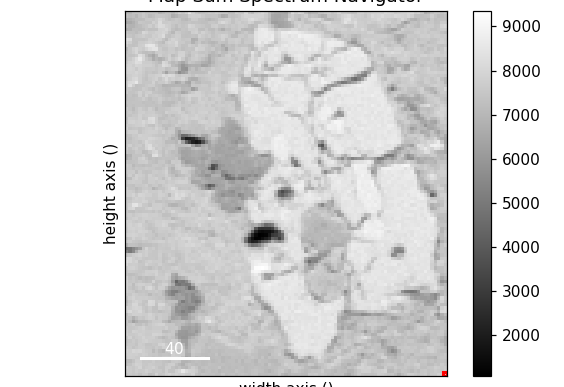

<IPython.core.display.Javascript object>


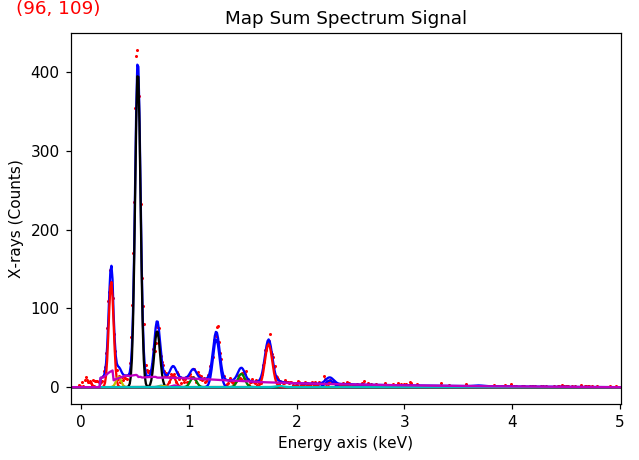

D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:307: RuntimeWarning: divide by zero encountered in log
  mac_res = np.exp(np.log(macs[index - 1]) +
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:308: RuntimeWarning: divide by zero encountered in true_divide
  np.log(macs[index] / macs[index - 1]) *
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: divide by zero encountered in true_divide
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:309: RuntimeWarning: invalid value encountered in log
  (np.log(energies / energies_db[index - 1]) /
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: divide by zero encountered in true_divide
  np.log(energies_db[index] / energies_db[index - 1])))
D://Users/Documents/GitHub/ZanettaPM/hyperspy/hyperspy\misc\material.py:310: RuntimeWarning: invalid valu

In [52]:
m3.plot(plot_components=True)

The formulation of the function physical_background is : 

                                    IBr=KZ(E0-E)/E * 1-e^(-2χρx)/2χρx * C * W

The ρx is a free parameter fitted to the data during the multifit of the model m3

The result of the fit is contain in the parameter 'coefficients' of the Bremsstralhung component:

<IPython.core.display.Javascript object>


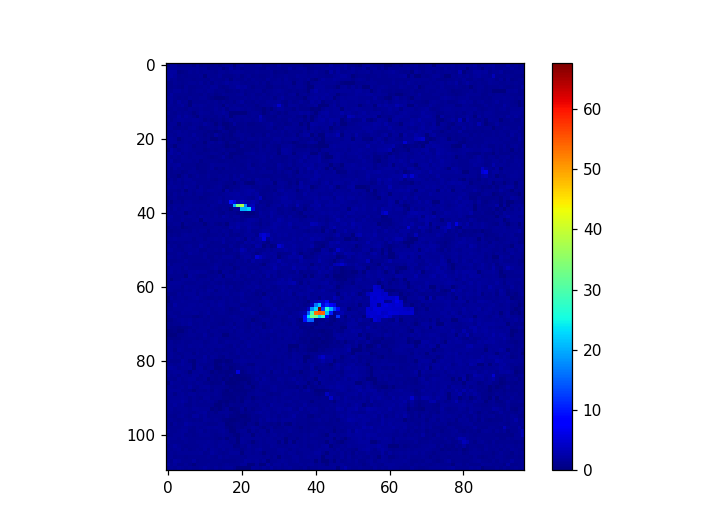

In [40]:
coef=(m3.components.Bremsstrahlung.coefficients.map['values'][:][:][:])
plt.figure()
plt.imshow(coef[:,:,0],cmap='jet')
plt.colorbar()

We create a map of the nominal density of the different phases to compare the proxy fitted to the real density

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


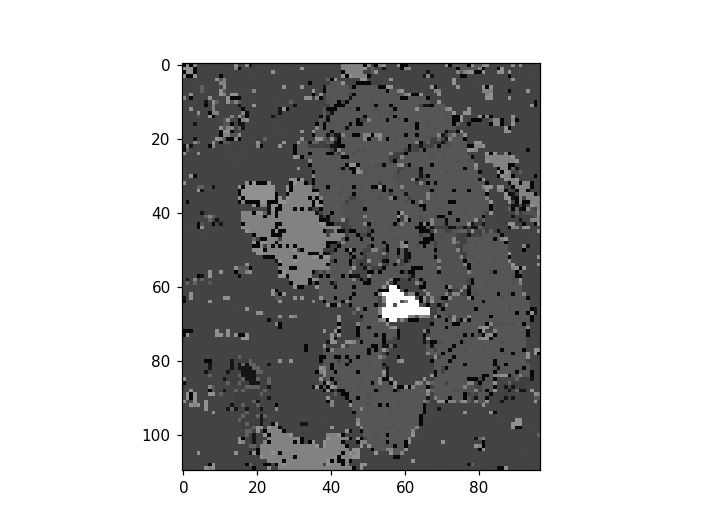

In [41]:
Density=[8.1,3.27,3.4,4.61,1.2,5,2.88,2.9,1.6,3.72,2.75,4]
x=np.shape(carto)
Dnom=np.ones([x[0],x[1],1])
Dnom=hs.signals.Signal1D(Dnom)


for i in range (1,np.max(carto)):
    a=np.where(carto==(i))
    x=np.shape(a)
    for u in range (0,x[1]):
        g=a[0]
        h=a[1]
        Dnom.inav[h[u],g[u]] =Density[i-1]
        
plt.figure()
plt.imshow(Dnom.data[:,:,0])

We calculate the mean value of the proxy for each phase to plot those results in 2D

In [42]:
Density=np.empty(np.max(carto))
Proxy=np.empty(np.max(carto))
for i in range (1,np.max(carto)):
    mask=carto==i
    Density[i]=np.nanmean(Dnom.data[:,:,0][mask])
    Proxy[i]=np.nanmean(coef[:,:,0][mask])

We calculate the linear regression to finally find the density of the of the amorphous/ phyllosilicate material.
Give that the number of pixels is really low and concentrated on a chondrule fragment the correlation is low

Do you want to plot the label of phases ? y/n
y


C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


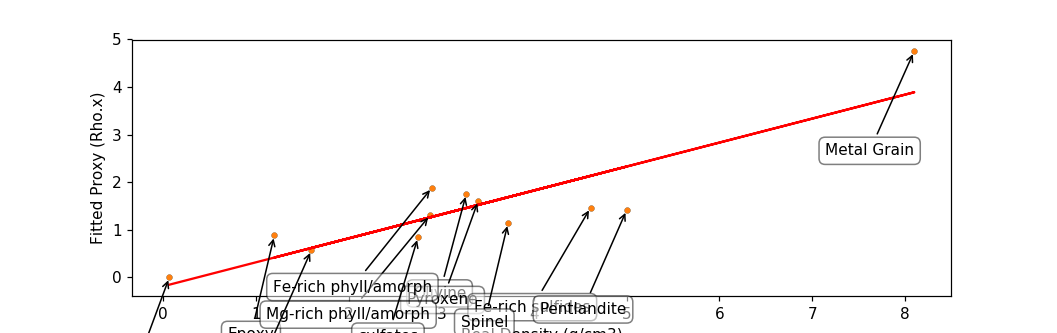

In [43]:
print('Do you want to plot the label of phases ? y/n')
test=input()
plt.figure()
plt.plot(Density,Proxy,'.')
from scipy import stats
x=np.transpose(Density)
y=Proxy

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, y, '.', label='data')
plt.plot(x, intercept + slope*x, 'r', label='fit')

if test=='y':
    labels=phases.copy()
    labels.insert(0,'nan_pixel')
    for label, x, y in zip(labels,x,y):
        plt.annotate(label,
            xy=(x, y), xytext=(0, -70),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.4', fc='white', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.xlabel('Real Density (g/cm3)')
    plt.ylabel('Fitted Proxy (Rho.x)')
else:  
    plt.xlabel('Real Density (g/cm3)')
    plt.ylabel('Fitted Proxy (Rho.x)')
#plt.title('Density proxy compare to real density')


We finally calculate the density map in function of the fitted proxy thanks to the linear relation between the two parameter

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


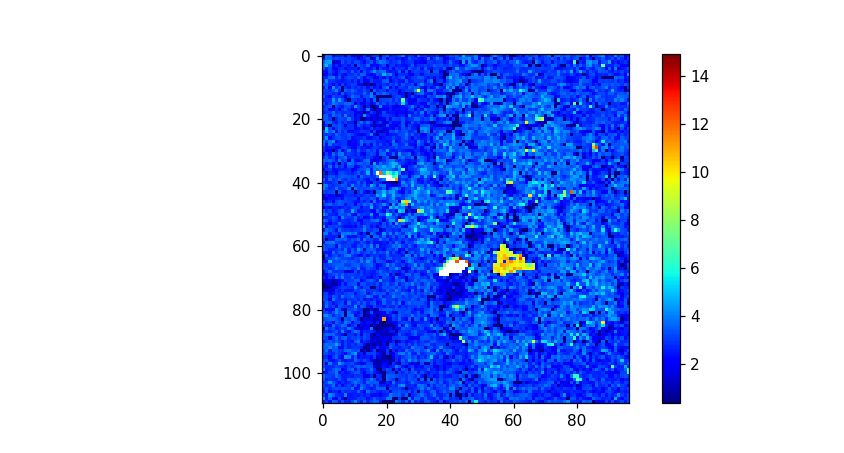

In [44]:
a=slope
b=intercept
Dcalc=((coef[:,:,0]-intercept)/slope)
mask=Dcalc>15
Dcalc[mask]=np.nan
plt.figure()
plt.imshow(Dcalc,cmap='jet')
plt.colorbar()

## 5. Calculation of the bulk composition <a class="anchor" id="fifth-bullet"></a>

We combine the modal abundance, the chemical composition and the density of each phase to calculate the bulk composition of the analyzed region 

We first extract the modal abundances from the MLLS procedure
And the density from the density map

In [45]:
AMfinal=np.ones(np.max(carto)-1)
for i in range (1,np.max(carto)):
    a=np.sum(m2[i].yscale.map['values']);
    AMfinal[i-1]=a/(s.axes_manager[0].size*s.axes_manager[1].size)

In [46]:
Dfinal=np.ones(np.max(carto)-1)
for i in range (1,np.max(carto)):
    maskD=Dcalc[carto==i]
    Dfinal[i-1]=np.nanmean(maskD)

In [47]:
print('|-----------------------------------------------------------------------|')
print('|                         Mineral mapping results                       |')
print('|-----------------------------------------------------------------------|')
print('|----------------------|------------------------|-----------------------|')
print('|         Phases       | Modal Abundances in %  |   Density in g/cm3    |')
for i in range (0,np.max(carto)-1):
    print('| {:20} |         {:.2f}           |         {:.2f}          |'.format(phases[i],AMfinal[i],Dfinal[i]))
print('|----------------------|------------------------|-----------------------|')

|-----------------------------------------------------------------------|
|                         Mineral mapping results                       |
|-----------------------------------------------------------------------|
|----------------------|------------------------|-----------------------|
|         Phases       | Modal Abundances in %  |   Density in g/cm3    |
| Metal Grain          |         0.06           |         9.81          |
| Olivine              |         0.29           |         3.85          |
| Pyroxene             |         0.03           |         3.58          |
| Fe-rich sulfides     |         0.00           |         3.24          |
| Epoxy                |         0.01           |         1.88          |
| Pentlandite          |         0.29           |         2.93          |
| Mg-rich phyll/amorph |         0.18           |         2.96          |
| Fe-rich phyll/amorph |         0.01           |         2.87          |
| Carbonates           |         0.01 

Finally we combine the three parameter to calculate the bulk composition:

In [48]:
BulkQuant=np.empty([len(s.metadata.Sample.elements)])
for i in range (0,np.max(carto)-1):        
    for k in range (0,len(s.metadata.Sample.elements)):
        BulkQuant[k]+=(AMfinal[i]*Dfinal[i]/np.mean(Dfinal))*Elmt[i][k]
BulkQuant=BulkQuant/np.sum(BulkQuant)*100

In [49]:
print('|-------------------------------|')
print('|      Global compositions      |')
print('|-------------------------------|')
print('|     Elements  |   Qti in Wt%  |')
print('|---------------|---------------|')
for i in range (0,len(s.metadata.Sample.elements)):
    print('|  {:3} (Wt. %)  |     {:5.2f}     |'.format(s.metadata.Sample.elements[i],BulkQuant[i]))
print('|---------------|---------------|')
print('|     Total     |    {:5.2f}     |'.format(np.sum(BulkQuant)))
print('|---------------|---------------|')

|-------------------------------|
|      Global compositions      |
|-------------------------------|
|     Elements  |   Qti in Wt%  |
|---------------|---------------|
|  Al  (Wt. %)  |      0.27     |
|  C   (Wt. %)  |      1.37     |
|  Ca  (Wt. %)  |      0.59     |
|  Fe  (Wt. %)  |     22.48     |
|  Mg  (Wt. %)  |     10.16     |
|  Na  (Wt. %)  |      1.57     |
|  Ni  (Wt. %)  |      6.69     |
|  O   (Wt. %)  |     21.37     |
|  S   (Wt. %)  |     13.09     |
|  Si  (Wt. %)  |     22.42     |
|---------------|---------------|
|     Total     |    100.00     |
|---------------|---------------|


Again, give that the number of pixels is really low and concentrated on a chondrule fragment with many sulfide the composition is quite far from the chondritic composition

To finish, this is the list of the used variables :

In [50]:
whos

Variable      Type              Data/Info
-----------------------------------------
AMfinal       ndarray           11: 11 elems, type `float64`, 88 bytes
BulkQuant     ndarray           10: 10 elems, type `float64`, 80 bytes
Carbonates    list              n=10
Dcalc         ndarray           110x97: 10670 elems, type `float64`, 85360 bytes
Density       ndarray           12: 12 elems, type `float64`, 96 bytes
Dfinal        ndarray           11: 11 elems, type `float64`, 88 bytes
Dnom          Signal1D          <Signal1D, title: , dimensions: (97, 110|1)>
Elmt          list              n=12
Epoxy         list              n=10
Fayalite      list              n=10
Fe_phyll      list              n=10
Fe_sulfides   list              n=10
Metal_grain   list              n=10
Mg_phyll      list              n=10
Olivine       list              n=10
Pentlandite   list              n=10
Proxy         ndarray           12: 12 elems, type `float64`, 96 bytes
Pyroxene      list              n